# Charging with PV Forecast

Previously, we tried to produce a charge profile by constructing optimal charge profiles for each day, and then using these optimal charge profiles as targets in our models.

Here we will try and predict the optimal charge profile by first forecasting PV, then constructing an optimal profile based on the forecast. TH

In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from moepy.lowess import quantile_model

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, utils

import FEAutils as hlp

In [18]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'
charge_opt_model_fp = '../models/charge_opt.sav'

In [25]:
def prepare_training_input_data(intermediate_data_dir, start_hour=5):
    # Loading input data
    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = charge.construct_df_charge_features(df)
    
    # Filtering for overlapping feature and target data
    dt_idx = pd.date_range(df_features.index.min(), df['pv_power_mw'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

    s_pv = df.loc[dt_idx, 'pv_power_mw']
    df_features = df_features.loc[dt_idx]
        
    # Filtering for evening datetimes
    charging_datetimes = charge.extract_charging_datetimes(df_features, start_hour=start_hour)
    
    X = df_features.loc[charging_datetimes]
    y = s_pv.loc[charging_datetimes]
    
    return X, y

In [26]:
X, y = prepare_training_input_data(intermediate_data_dir)

In [29]:
df_pred = clean.generate_kfold_preds(X.values, y.values, RandomForestRegressor(), index=X.index)

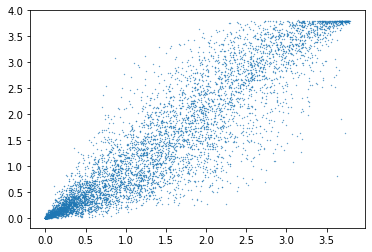

In [30]:
plt.scatter(df_pred.pred, df_pred.true, s=0.1)